### AI vs 사람 이미지 구별하기
[CSV 파일] : 실제 이미지 -> 파일 경로, label 저장  
->   
[Dataset] -> csv 읽어서 파일 경로로 파일을 연 후 이미지->텐서 변환  => (image tensor, label) 반환  
->  
[DataLoader] 여러개 묶어서 배치 생성    
->   
모델  
- 0/1 이진 분류 모델

In [3]:
## 모듈 로딩
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## 파이토치
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## 이미지 토치 모듈
import torchvision
from torchvision import transforms

from PIL import Image

In [4]:
import torchvision
import inspect

print("torchvision file:", torchvision.__file__)
print("has transforms:", hasattr(torchvision, "transforms"))
print("dir contains transforms:", "transforms" in dir(torchvision))


torchvision file: c:\Users\kdt58\anaconda3\envs\TORCH_38\lib\site-packages\torchvision\__init__.py
has transforms: True
dir contains transforms: True


In [5]:
## ------------------------------------------------------
## 데이터 준비 : 이미지 정보 -> csv로 저장 (파일경로, 라벨)
## ------------------------------------------------------
## 데이터 경로 디렉토리
data_dir = "AI_VS_REAL"

## 라벨 매핑 - 가짜 : 0 / 진짜 : 1
label_map = {"FAKE":0,"REAL":1}

## 함수 기능 : img 경로, 라벨 -> csv로 저장
def img_to_csv(split):
    rows = []

    split_dir = os.path.join(data_dir, split)

    ## real/fake 폴더 돌기
    for class_name, label in label_map.items():
        class_dir = os.path.join(split_dir, class_name)

        for fname in os.listdir(class_dir):
            filepath  = os.path.join(class_dir, fname)
            rows.append({"filepath":filepath, "label":label})

    ## 데이터 프레임으로 저장
    df = pd.DataFrame(rows)

    csv_name = f"{split}.csv"

    df.to_csv(csv_name,index=False)

    print(f"{csv_name} {len(df)}개 생성 완료 ")

    return df
## 일단 train 데이터 저장
train_df = img_to_csv("train")

train_df.head(2)


train.csv 100000개 생성 완료 


,filepath,label
0,AI_VS_REAL\train\FAKE\1000 (10).jpg,0
1,AI_VS_REAL\train\FAKE\1000 (2).jpg,0


In [6]:
## 훈련/검증용 데이터 분리
df = pd.read_csv('./train.csv')


## 왜 x_train,x_valid,y_train,y_valid로 안나누냐?
## -> 이런 경우는 csv 처럼 정형 데이터로 X/y를 미리 분리해야하는데,
##    이미지 데이터의 경우 X/y가 Dataset의 __getitem__ 안에서 생성 => 2개로 나눔
## => split 대상은 [filepath, label] 목록
train_df,valid_df = train_test_split(df,test_size=0.1,## 검증 비율 10%
                                     random_state=512,
                                     shuffle=True,
                                     stratify=df["label"])  # Fake/Real 비율 유지
## 인덱스 정리
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)


In [7]:
## ------------------------------------------------------
## 데이터셋 클래스 정의
## ------------------------------------------------------
class csvImgDataset(Dataset):
    def __init__(self, csv_path, transform = None):
        super().__init__()
        ## csv 로드
        self.df =df.reset_index(drop = True)
        ## 전처리 저장
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        ## img_tensor : (C,H,W) 형태 토치 텐서
        row = self.df.iloc[idx] ##csv 에서 행 읽기

        img_path = row['filepath']
        label = int(row["label"])

        ## 이미지 파일 그때그때 열기
        img=Image.open(img_path).convert("RGB")
        
        ## 전처리 적용
        if self.transform is not None:
            img = self.transform(img)

        ## 라벨 -> 토치 텐서로 반환
        label = torch.tensor(label, dtype= torch.float32)

        ## (feature, target) 반환 
        ## - img 텐서 / label 텐서
        return img, label


In [8]:
## PIL 이미지 -> torch.tensor 
## shape : (H,W,c) -> (C, H, W)
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

## 검증/테스트 용
val_transforms = transforms.Compose([transforms.ToTensor()])

In [9]:
train_ds = csvImgDataset(train_df, transform=train_transforms)
val_ds = csvImgDataset(valid_df, transform=val_transforms)

## test.csv
test_df = img_to_csv("test")
test_ds = csvImgDataset(test_df, transform=val_transforms)

print(len(train_ds), len(val_ds), len(test_ds))

test.csv 20000개 생성 완료 
100000 100000 100000


In [10]:
## 샘플 확인
x, y = train_ds[0]
print(x.shape)   # torch.Size([3, 32, 32])
print(y) 

torch.Size([3, 32, 32])
tensor(0.)


In [11]:
## 데이터 로더
BATCH_SIZE = 64

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)
val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [12]:
## ------------------------------------------------------
## 모델 이진 분류 클래스
## Flatten
## : 이미지 (3x32x32) -> 1차원 벡터로
## ------------------------------------------------------
from torchvision import models

class imgModel(nn.Module):
    def __init__(self, img_h=32, img_w=32, channels=3, hidden1=512, hidden2=128, dropout_p=0.3):
        super().__init__()
        ## 입력차원 3*32*32
        in_dim  = channels*img_h*img_w

        self.net = nn.Sequential(nn.Flatten(),
                                 nn.Linear(in_dim, hidden1),
                                 nn.ReLU(),
                                 nn.Dropout(p = dropout_p),
                                 
                                 nn.Linear(hidden1,hidden2),
                                 nn.ReLU(),
                                 nn.Dropout(p=dropout_p),
                                 
                                 nn.Linear(hidden2, 1))     ## logits 1개
    def forward(self,x):
        ## 출력 : logits shape(B,1)
        return self.net(x)
        

In [13]:
## loss/optimizer 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

model = imgModel(img_h=32, img_w=32, hidden1=512, hidden2=128, dropout_p=0.3).to(device)

## 이진 분류 표준 : sigmoid를 loss가 내부적으로 처리
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )

In [14]:
# ===============================
# 모델 저장 경로
# ===============================
IMG_MODEL = "../Models/img_model.pt"        # 모델 전체 저장
IMG_WEIGHTS_MODEL = "../Models/img_weights.pt"  # 가중치만 저장

In [15]:
## ---------------------------------------
## 학습 루프
## ---------------------------------------
## 한 epoch 함수
## model : 학습할 신경망 imgModel
## criterion : 손실함수 BCEWithLogitsLoss
## ---------------------------------------
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    ## 모델을 학습모드로 전환
    ## dropout 활성화
    model.train()
    total_loss = 0.0    ## epoch 전체 loss 합
    correct = 0           # 맞춘 개수
    total = 0             # 전체 샘플 수

    ## 배치 단위 반복
    for images, labels in dataloader:

        ## GPU로 데이터 이동
        images = images.to(device)

        # BCEWithLogitsLoss는
        # - label이 float
        # - shape이 (B, 1)
        labels = labels.float().unsqueeze(1).to(device)

        ## 이전 batch에서 남은 기울기 초기화
        optimizer.zero_grad()

        ## forward (예측) : 순전파 
        logits = model(images)        # (B, 1)
        ## 손실 계산
        loss = criterion(logits, labels)
        ## backward (미분)
        loss.backward()
        ## 파라미터 업데이트
        optimizer.step()
        ## 통계 누적
        total_loss += loss.item() * images.size(0)

        ## accuracy 계산
        probs = torch.sigmoid(logits)      # 확률 (0~1)
        preds = (probs >= 0.5).float()     # 0/1 예측값

        correct += (preds == labels).sum().item()
        total += labels.numel()

    # epoch 평균 loss / accuracy
    avg_loss = total_loss / len(dataloader.dataset)
    acc = correct / total

    return avg_loss, acc


In [16]:
## ---------------------------------------
## 평가 루프
## ---------------------------------------
## 검증 / 테스트 함수
## -> 가중치 업데이트 X
## - 성능 측정 전용
## ---------------------------------------
@torch.no_grad()
def evaluate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    tp = fp = fn = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()

        correct += (preds == labels).sum().item()
        total += labels.numel()

        tp += ((preds == 1) & (labels == 1)).sum().item()
        fp += ((preds == 1) & (labels == 0)).sum().item()
        fn += ((preds == 0) & (labels == 1)).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    acc = correct / total

    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)

    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    return avg_loss, acc, f1


In [17]:
# ## ---------------------------------------
# ## 학습 진행
# ## ---------------------------------------
# epochs = 20
# best_val_acc = 0.0

# for epoch in range(1, epochs+1):
#     ## 업데이트 o
#     train_loss, train_acc = train_one_epoch(model, train_ld, optimizer, criterion, device)
#     ## 업데이트 x
#     val_loss, val_acc, val_prec, val_rec = evaluate(model, val_ld, criterion, device)

#     print(
#         f"[{epoch:02d}] "
#         f"TRAIN loss={train_loss:.4f} acc={train_acc:.4f} | "
#         f"VAL loss={val_loss:.4f} acc={val_acc:.4f} "
#         f"prec={val_prec:.4f} rec={val_rec:.4f}"
#     )

#   ## 가장 성능 좋은 모델 저장
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc

#         ## 모델 전체 저장
#         torch.save(model, IMG_MODEL)

#         ## 가중치만 저장 (권장)
#         torch.save(model.state_dict(), IMG_WEIGHTS_MODEL)

#         print(f"Best model saved! (val_acc={best_val_acc:.4f})")  

In [18]:
import torch
import matplotlib.pyplot as plt

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

epochs = 50

## Early Stopping 설정
patience = 6          # 개선이 없을 때 몇 epoch까지 기다릴지
min_delta = 1e-4      # 이만큼 이상 좋아져야 "개선"으로 인정(너무 미세한 흔들림 무시)

best_val_f1 = 0.0
no_improve = 0

for epoch in range(1, epochs + 1):
    ## 학습
    train_loss, train_acc = train_one_epoch(model, train_ld, optimizer, criterion, device)

    ## 검증 
    val_loss, val_acc, val_f1 = evaluate(model, val_ld, criterion, device)

    ## 기록
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(
        f"[{epoch:02d}] "
        f"TRAIN loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"VAL loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}"
    )

    ## Best 갱신 & 저장
    if val_f1 > best_val_f1 + min_delta:
        best_val_f1 = val_f1
        no_improve = 0

        torch.save(model, IMG_MODEL)
        torch.save(model.state_dict(), IMG_WEIGHTS_MODEL)
        print(f"Best model saved! (val_f1={best_val_f1:.4f})")

    else:
        no_improve += 1
        print(f"  (no improve: {no_improve}/{patience})")

    ## Early Stopping
    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch}. Best val_f1={best_val_f1:.4f}")
        break


[01] TRAIN loss=0.6107 acc=0.6505 | VAL loss=0.5647 acc=0.7075 f1=0.6983
Best model saved! (val_f1=0.6983)
[02] TRAIN loss=0.5718 acc=0.6952 | VAL loss=0.5472 acc=0.7262 f1=0.7158
Best model saved! (val_f1=0.7158)
[03] TRAIN loss=0.5535 acc=0.7111 | VAL loss=0.5265 acc=0.7381 f1=0.7228
Best model saved! (val_f1=0.7228)
[04] TRAIN loss=0.5444 acc=0.7191 | VAL loss=0.5323 acc=0.7390 f1=0.7190
  (no improve: 1/6)
[05] TRAIN loss=0.5393 acc=0.7209 | VAL loss=0.5416 acc=0.7237 f1=0.6813
  (no improve: 2/6)
[06] TRAIN loss=0.5317 acc=0.7289 | VAL loss=0.5364 acc=0.7289 f1=0.6790
  (no improve: 3/6)
[07] TRAIN loss=0.5301 acc=0.7276 | VAL loss=0.5388 acc=0.7225 f1=0.6593
  (no improve: 4/6)
[08] TRAIN loss=0.5280 acc=0.7298 | VAL loss=0.5320 acc=0.7356 f1=0.6892
  (no improve: 5/6)
[09] TRAIN loss=0.5227 acc=0.7347 | VAL loss=0.5282 acc=0.7363 f1=0.6881
  (no improve: 6/6)
Early stopping at epoch 9. Best val_f1=0.7228


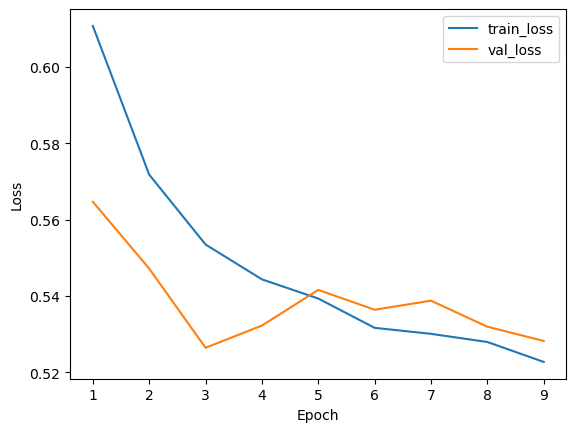

In [19]:
## ----------------------------------------
## Loss 그래프 (Train vs Val)
## => Train Loss 전체적으로 감소
##    12~14 epoch 근처가 일반화 성능 최적
##    -> 이후엔 과적합 신호
## ----------------------------------------
epochs_axis = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_axis, history["train_loss"], label="train_loss")
plt.plot(epochs_axis, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


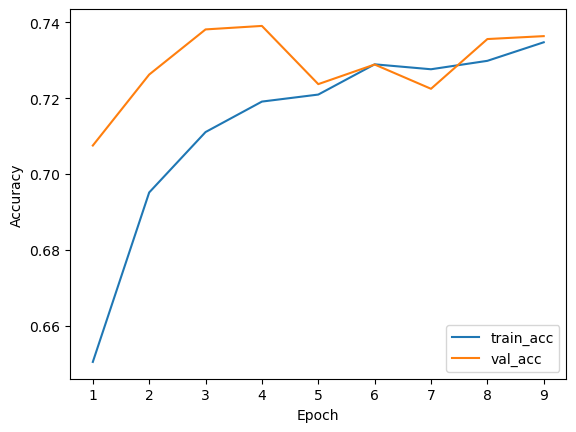

In [20]:
## ---------------------------------------------
## Accuracy 그래프
## train_acc - 점점 상승
## val_acc - 초반 변동 큼 -> 12~18 사이 최고치
## ---------------------------------------------
plt.figure()
plt.plot(epochs_axis, history["train_acc"], label="train_acc")
plt.plot(epochs_axis, history["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


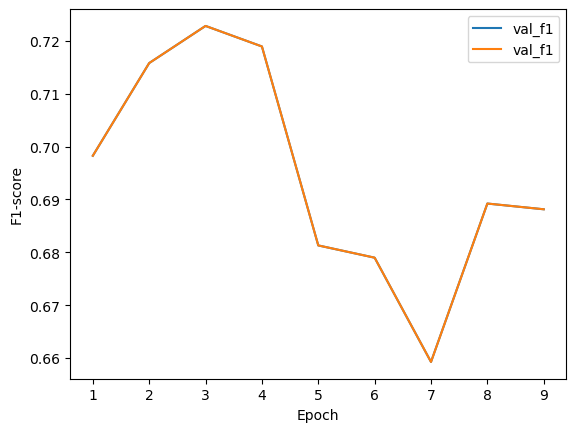

In [21]:
## ---------------------------------------------
## F1-score 그래프
## ---------------------------------------------
plt.figure()
plt.plot(epochs_axis, history["val_f1"], label="val_f1")
plt.plot(epochs_axis, history["val_f1"], label="val_f1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.show()


In [27]:
## best 가중치 모델 로드
model.load_state_dict(torch.load(IMG_WEIGHTS_MODEL, map_location=device))
model.to(device)
model.eval()

## test 평가 (evaluate 함수 재사용)
test_loss, test_acc, test_f1 = evaluate(model, test_ld, criterion, device)

print(f"[TEST] loss={test_loss:.4f} | acc={test_acc:.4f} | f1={test_f1:.4f}")

[TEST] loss=0.5265 | acc=0.7381 | f1=0.7228


In [23]:
## -----------------------------------------------------
## 단일 이미지 맞추기 함수
## - 흐름 : 이미지파일 -> PIL 로드 -> resize + totensor
##          -> tensor 배치화 -> 모델 로드 -> 시그모이드 => 판단
## -----------------------------------------------------

from torchvision import transforms
## 이미지 크기 리사이징
inference_tfms = transforms.Compose([
    transforms.Resize((32, 32)),   
    transforms.ToTensor(),            # PIL → Tensor (0~1)
])


def predict_single_image(img_path,   ## 이미지 파일 경로
                         model,      ## 학습 모델
                         device,     ## gpu
                         transform,  ## resize
                         threshold=0.5,
                         class_names=("REAL", "FAKE")):
    ## 모델 평가
    model.eval()

    ## 이미지 파일 -> pil 이미지로
    img = Image.open(img_path).convert("RGB")

    ## 전처리
    x = transform(img)    ## (3, 32, 32)
    x = x.unsqueeze(0)    ## 모델은 배치단위로 입력을 받으니까 : 1장 받을때 => 배치 1 (1, 3, 32, 32)
    x = x.to(device)

    ## 추론
    with torch.no_grad():
        logits = model(x)                   
        prob = torch.sigmoid(logits).item()     ## fake일 확률 

    ## 0/1 판정하기
    raw_pred = 1 if prob >= threshold else 0
    label = class_names[raw_pred]

    return {
        "raw_pred": raw_pred,           ## 0 / 1
        "label": label,                 ## REAL / FAKE
        "probability": prob             ## 그렇다고 확신하는 확률
    }


- 예측하기

In [46]:
## threshold : 확률을 0/1로 바꾸는 기준선
## 동물 사진 
result = predict_single_image(img_path="ai_img.jpg",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])


result = predict_single_image(img_path="real_img.jpg",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])


0/1 output : 1
F/R        : FAKE
probability: 0.5693817138671875
0/1 output : 1
F/R        : FAKE
probability: 0.6071987748146057


In [47]:
## 사람 증명 사진
result = predict_single_image(img_path="ai_img2.jpg",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])

result = predict_single_image(img_path="real_img2.jpg",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])


0/1 output : 1
F/R        : FAKE
probability: 0.6308475136756897
0/1 output : 0
F/R        : REAL
probability: 0.2929512858390808


In [55]:
## 음식 사진
result = predict_single_image(img_path="ai_img3.png",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])

result = predict_single_image(img_path="real_img3.jpg",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])

0/1 output : 0
F/R        : REAL
probability: 0.20202666521072388
0/1 output : 1
F/R        : FAKE
probability: 0.8524566888809204


In [49]:
## 배경 사진
result = predict_single_image(img_path="ai_img4.png",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])

result = predict_single_image(img_path="real_img4.jpg",
                              model=model,
                              device=device,
                              transform=inference_tfms,
                              threshold=0.5,
                              class_names=("REAL", "FAKE"))

print("0/1 output :", result["raw_pred"])
print("F/R        :", result["label"])
print("probability:", result["probability"])

0/1 output : 1
F/R        : FAKE
probability: 0.5464293360710144
0/1 output : 0
F/R        : REAL
probability: 0.19664713740348816
